In [424]:
import tqdm as tqdm
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

I decided to use Covid-19 Russia Dataset from https://datalens.yandex/7o7is1q6ikh23?tab=X1
And I took data which is related to number of dethes people in Sain-Petersburg

In [425]:
df = pd.read_csv("data/Таблица_2022-09-10_17-00.csv", sep=";", parse_dates=["Дата"], infer_datetime_format=True)
df = df[df["Регион"] == "Санкт-Петербург"].set_index("Дата").sort_index()[["Смертей за день"]]
df.head()

,Смертей за день
Дата,
2020-03-12,0
2020-03-13,0
2020-03-14,0
2020-03-15,0
2020-03-16,0


In [426]:
# There is a many data to test our predictions
df.tail()

,Смертей за день
Дата,
2022-09-06,21
2022-09-07,22
2022-09-08,19
2022-09-09,20
2022-09-10,14


In [427]:
# Take one year's data
df = df['2021-01-01':'2022-03-01'] # 365 days '2021-12-31' and plus 60 days more for testing
df.head()

,Смертей за день
Дата,
2021-01-01,75
2021-01-02,76
2021-01-03,80
2021-01-04,79
2021-01-05,73


In [428]:
# One year
len(df)

425

In [429]:
df.rename(columns={"Смертей за день": "Death_day"}, inplace=True)
df.index.names = ["Date"]

In [430]:
df.head()

,Death_day
Date,
2021-01-01,75
2021-01-02,76
2021-01-03,80
2021-01-04,79
2021-01-05,73


<AxesSubplot:xlabel='Date'>

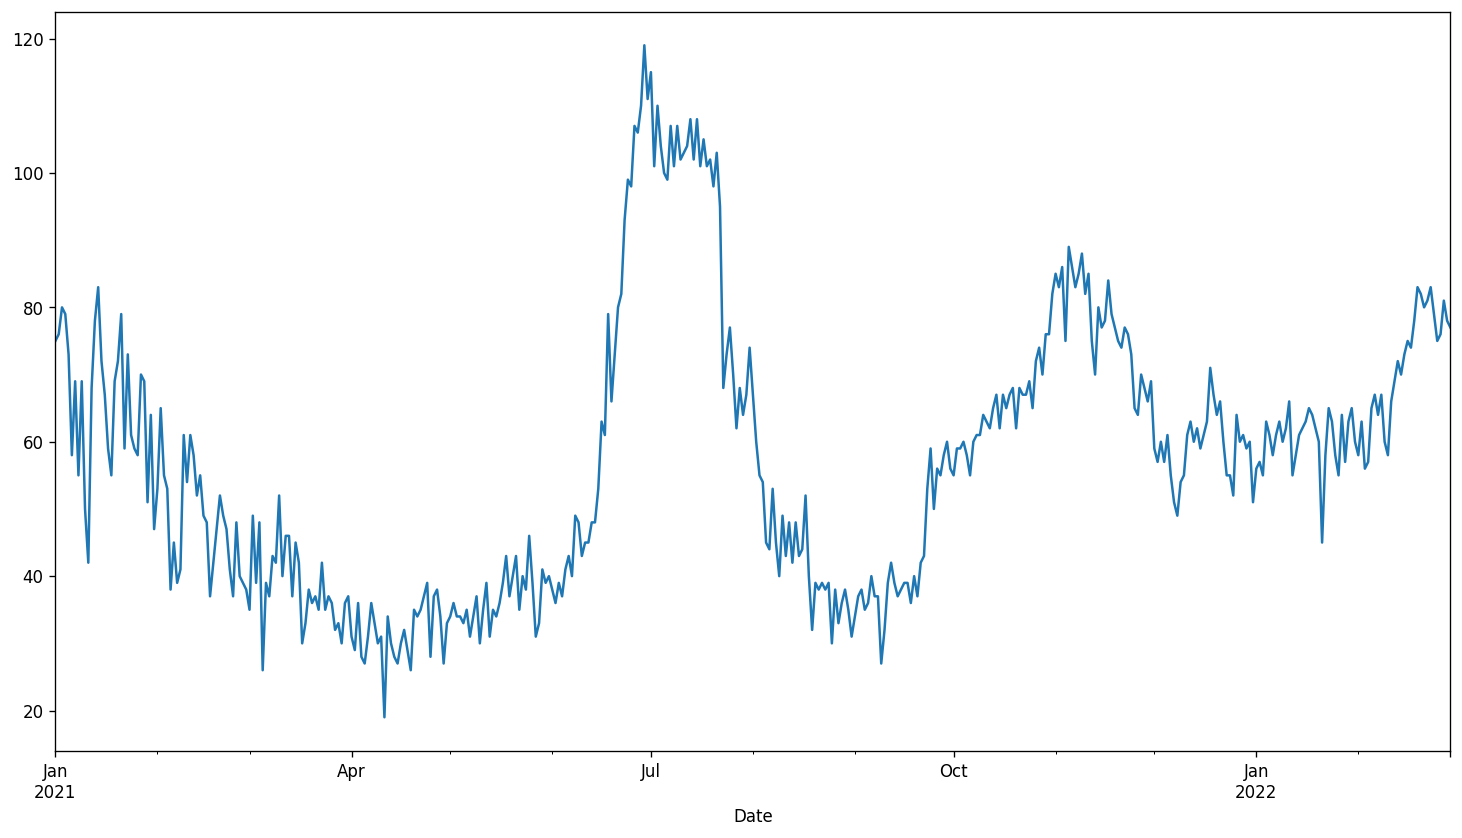

In [431]:
plt.figure(figsize=(15,8))
df.Death_day.plot()

# SARIMA
Good article about choosing model params https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/
and https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

In [432]:
df_test = df['2021-12-31': '2022-03-01']
df_train = df['2021-01-01': '2021-12-31']

In [433]:
df_train.head()

,Death_day
Date,
2021-01-01,75
2021-01-02,76
2021-01-03,80
2021-01-04,79
2021-01-05,73


In [434]:
len(df_train)

365

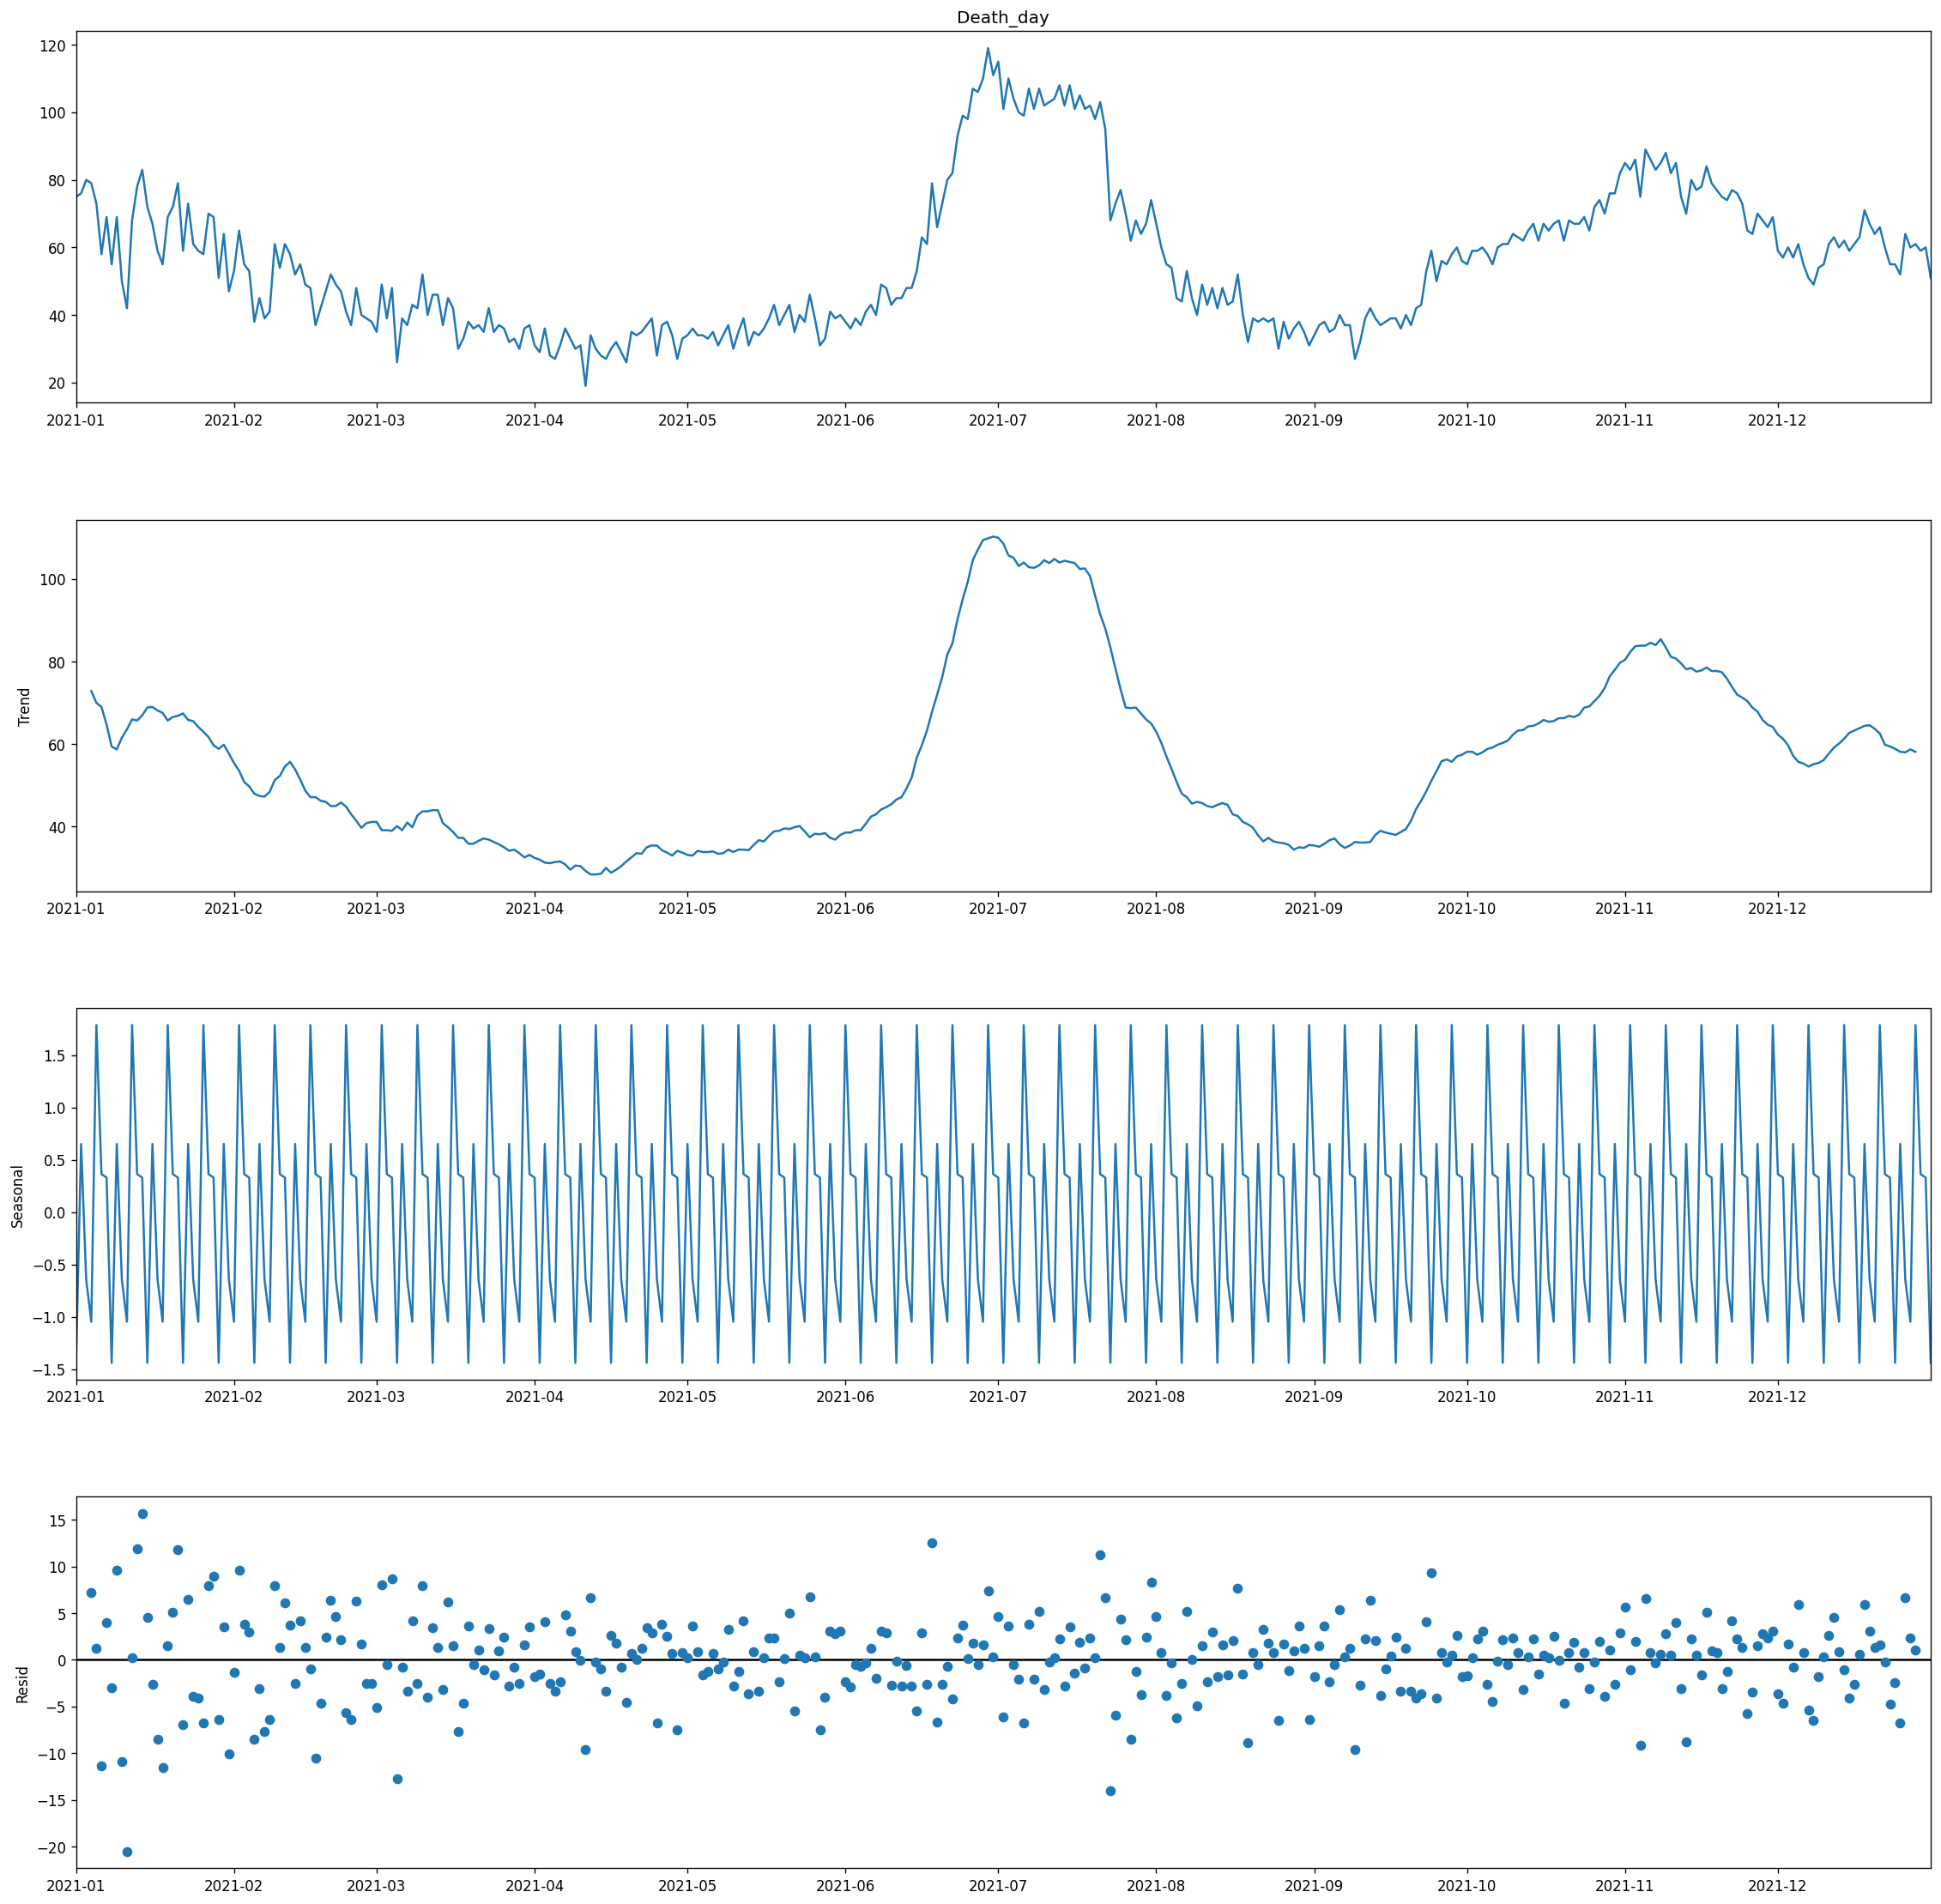

In [435]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

fig = sm.tsa.seasonal_decompose(df_train.Death_day).plot()
fig.set_size_inches((20,20))

In [436]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Death_day)[1])

Dickey-Fuller test: p=0.293619


# Well, p > 0.05 and then time series non-stationary

Best Box-Cox parameter: -0.237584
Dickey-Fuller test: p=0.441165


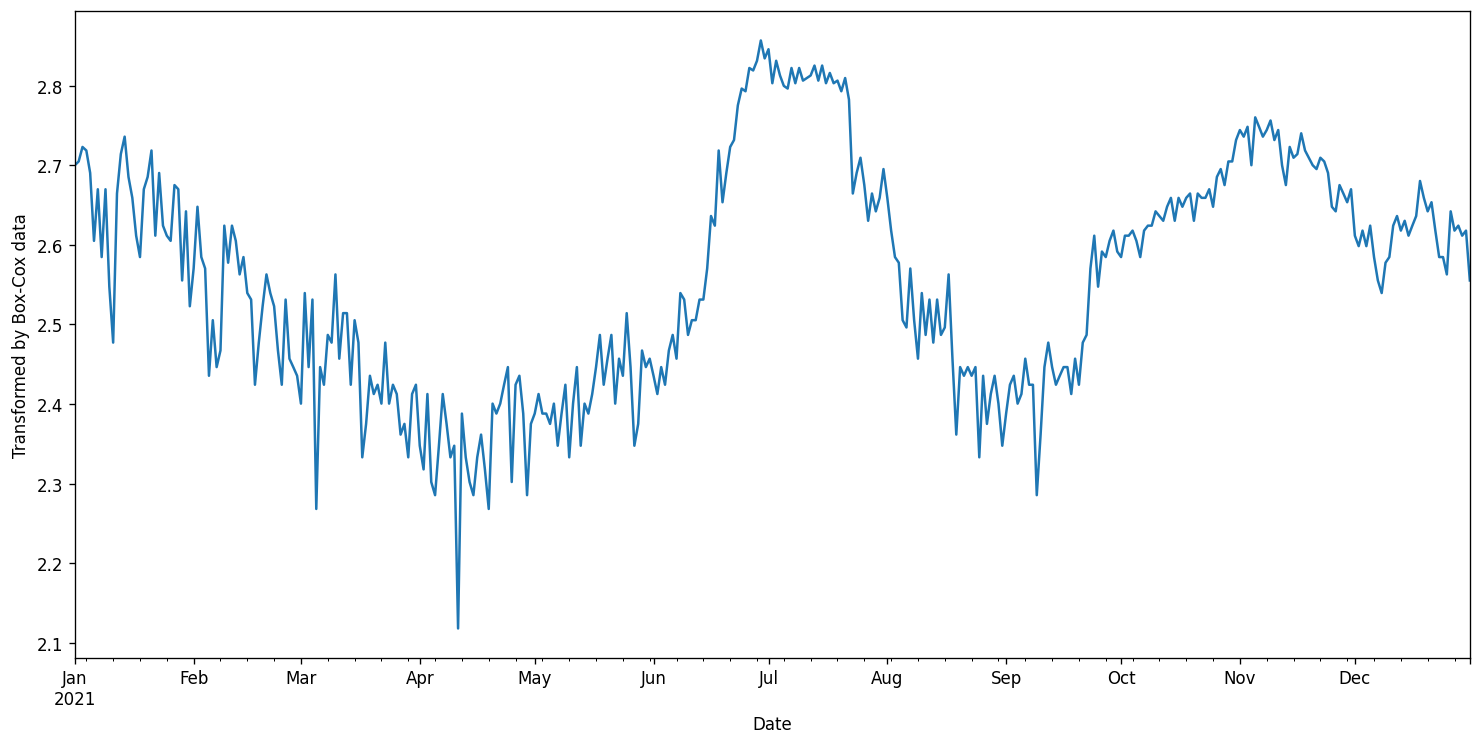

In [437]:
# Box-Cox transformation for dispersion stationarity

df_train['Death_day_box'], lmbda = stats.boxcox(df_train.Death_day)
plt.figure(figsize=(15,7))
df_train.Death_day_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Death_day_box)[1])

Dickey-Fuller test: p=0.057651


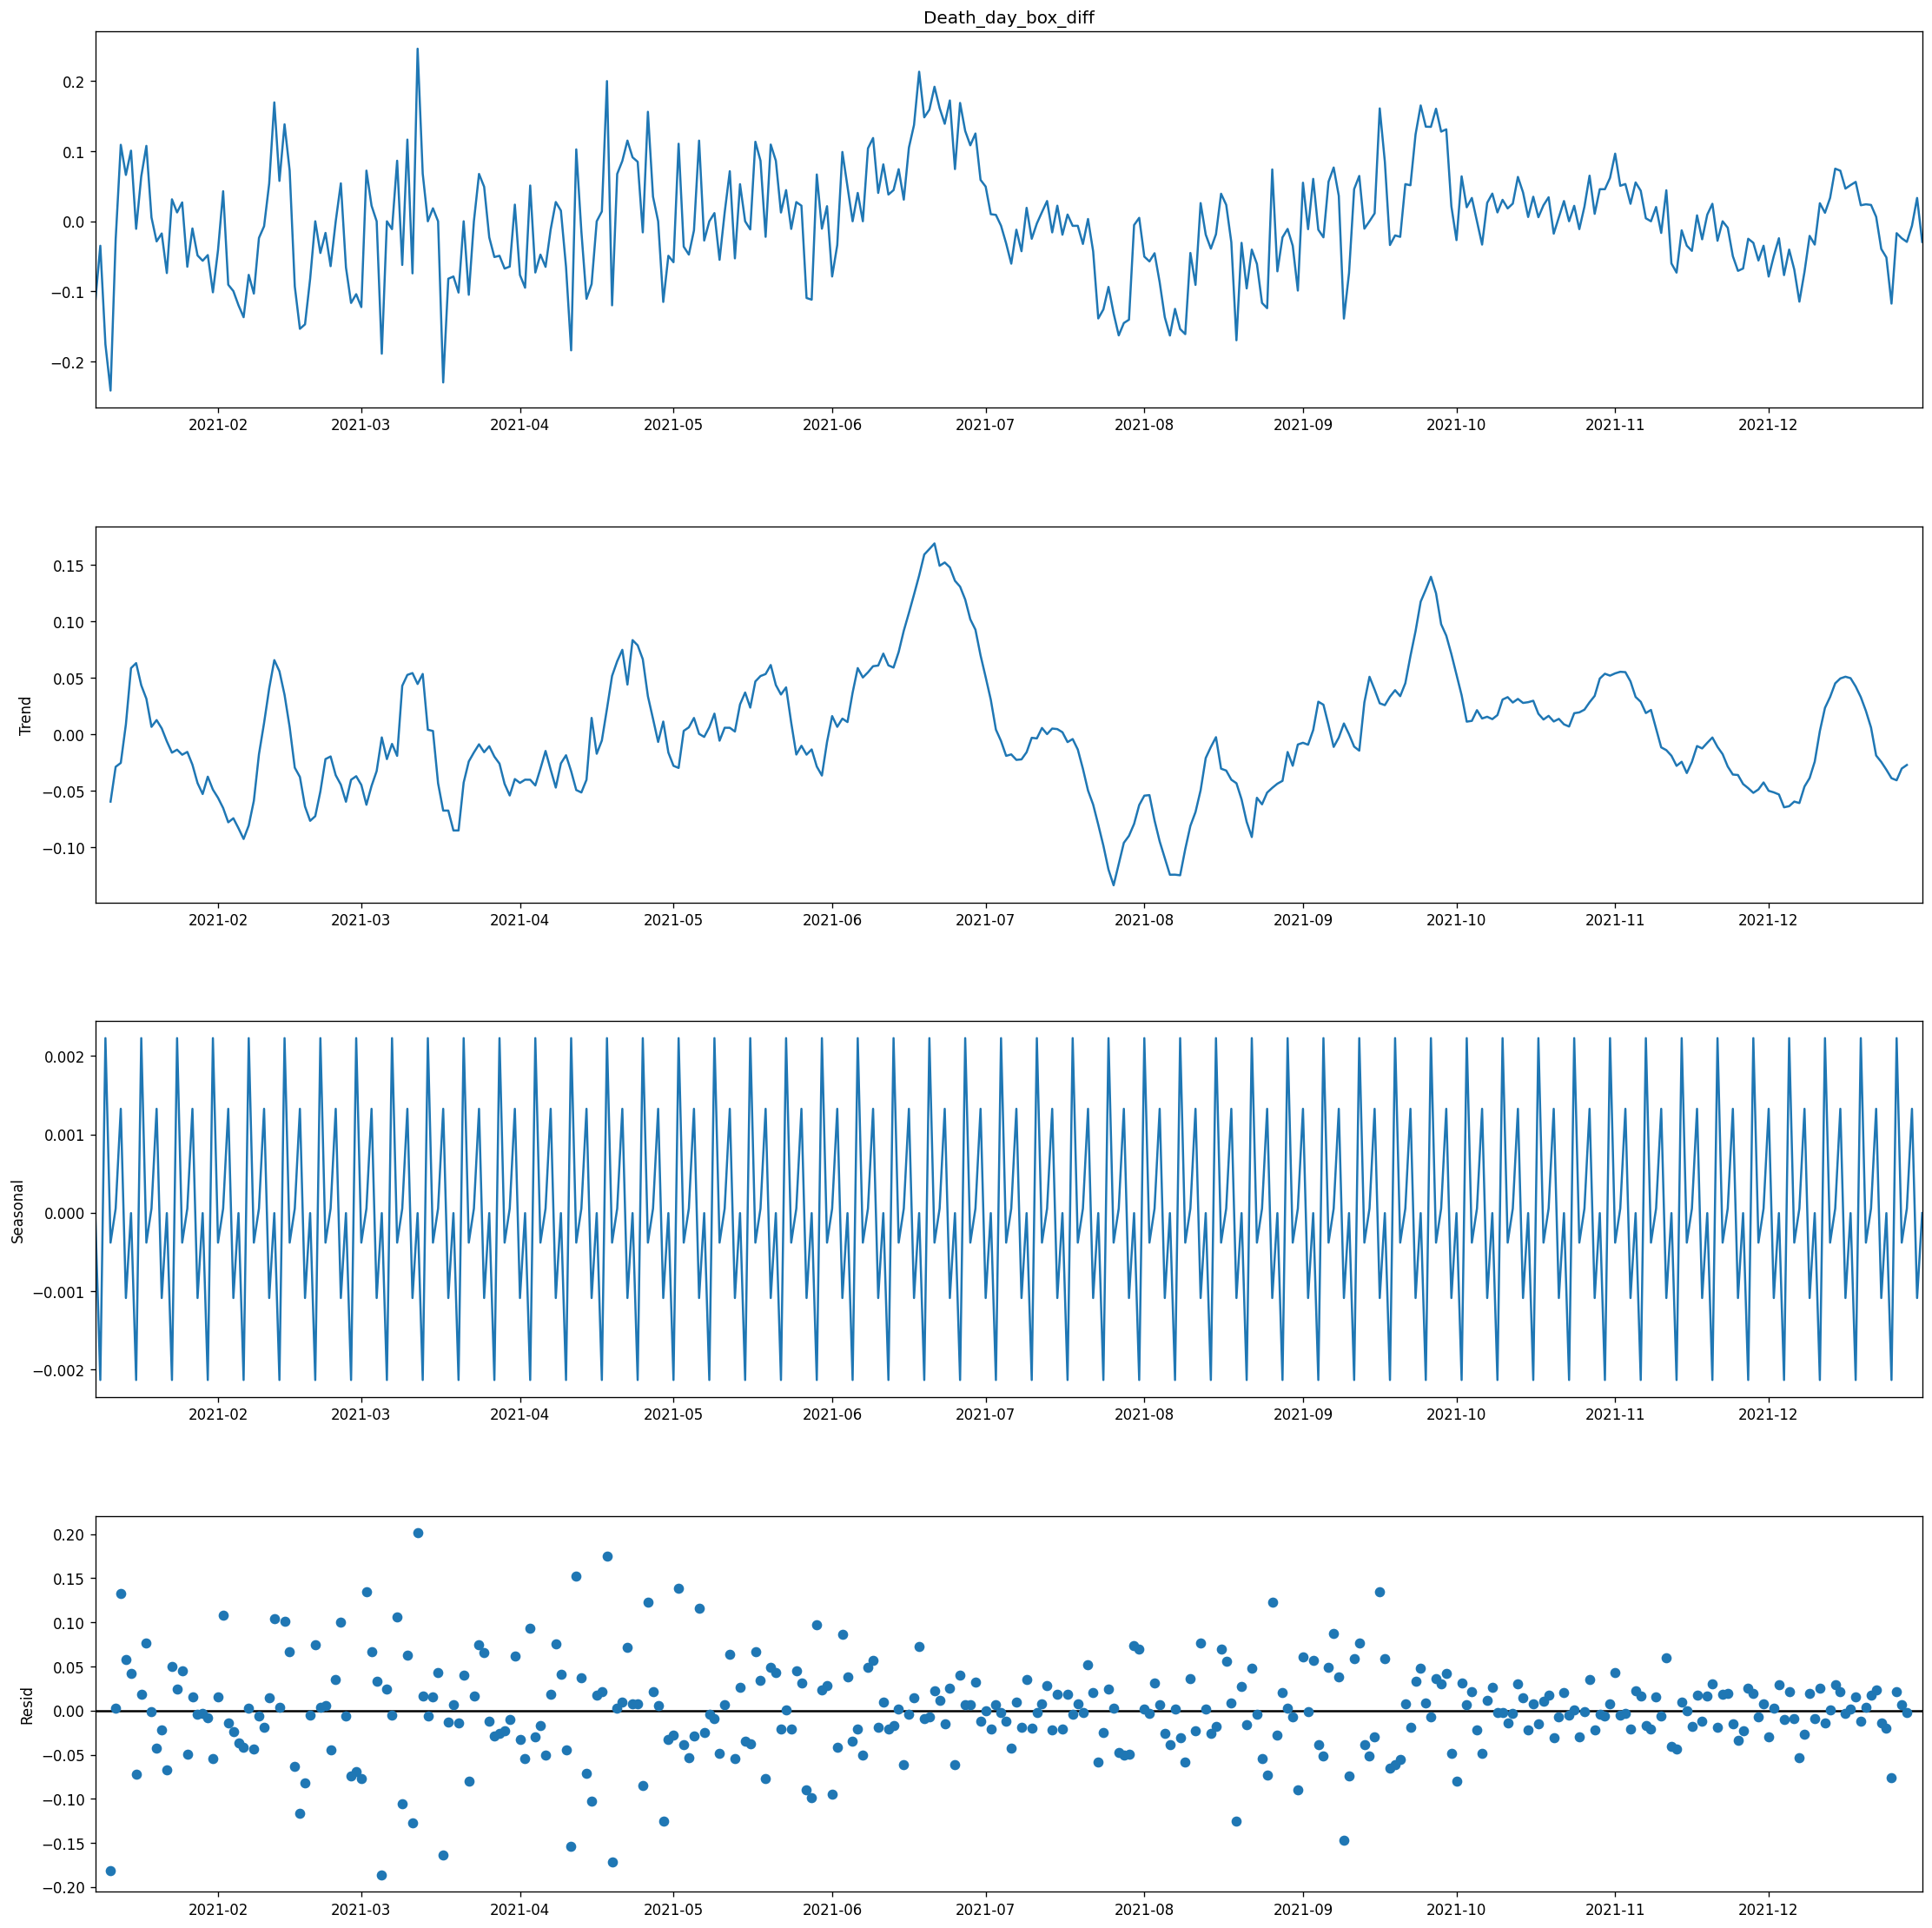

In [438]:
# seasonal difference for 7 days

df_train['Death_day_box_diff'] = df_train.Death_day_box - df_train.Death_day_box.shift(7)
fig = sm.tsa.seasonal_decompose(df_train.Death_day_box_diff[7:]).plot()
fig.set_size_inches((20,20))
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Death_day_box_diff[7:])[1])

Dickey-Fuller test: p=0.000000000016837


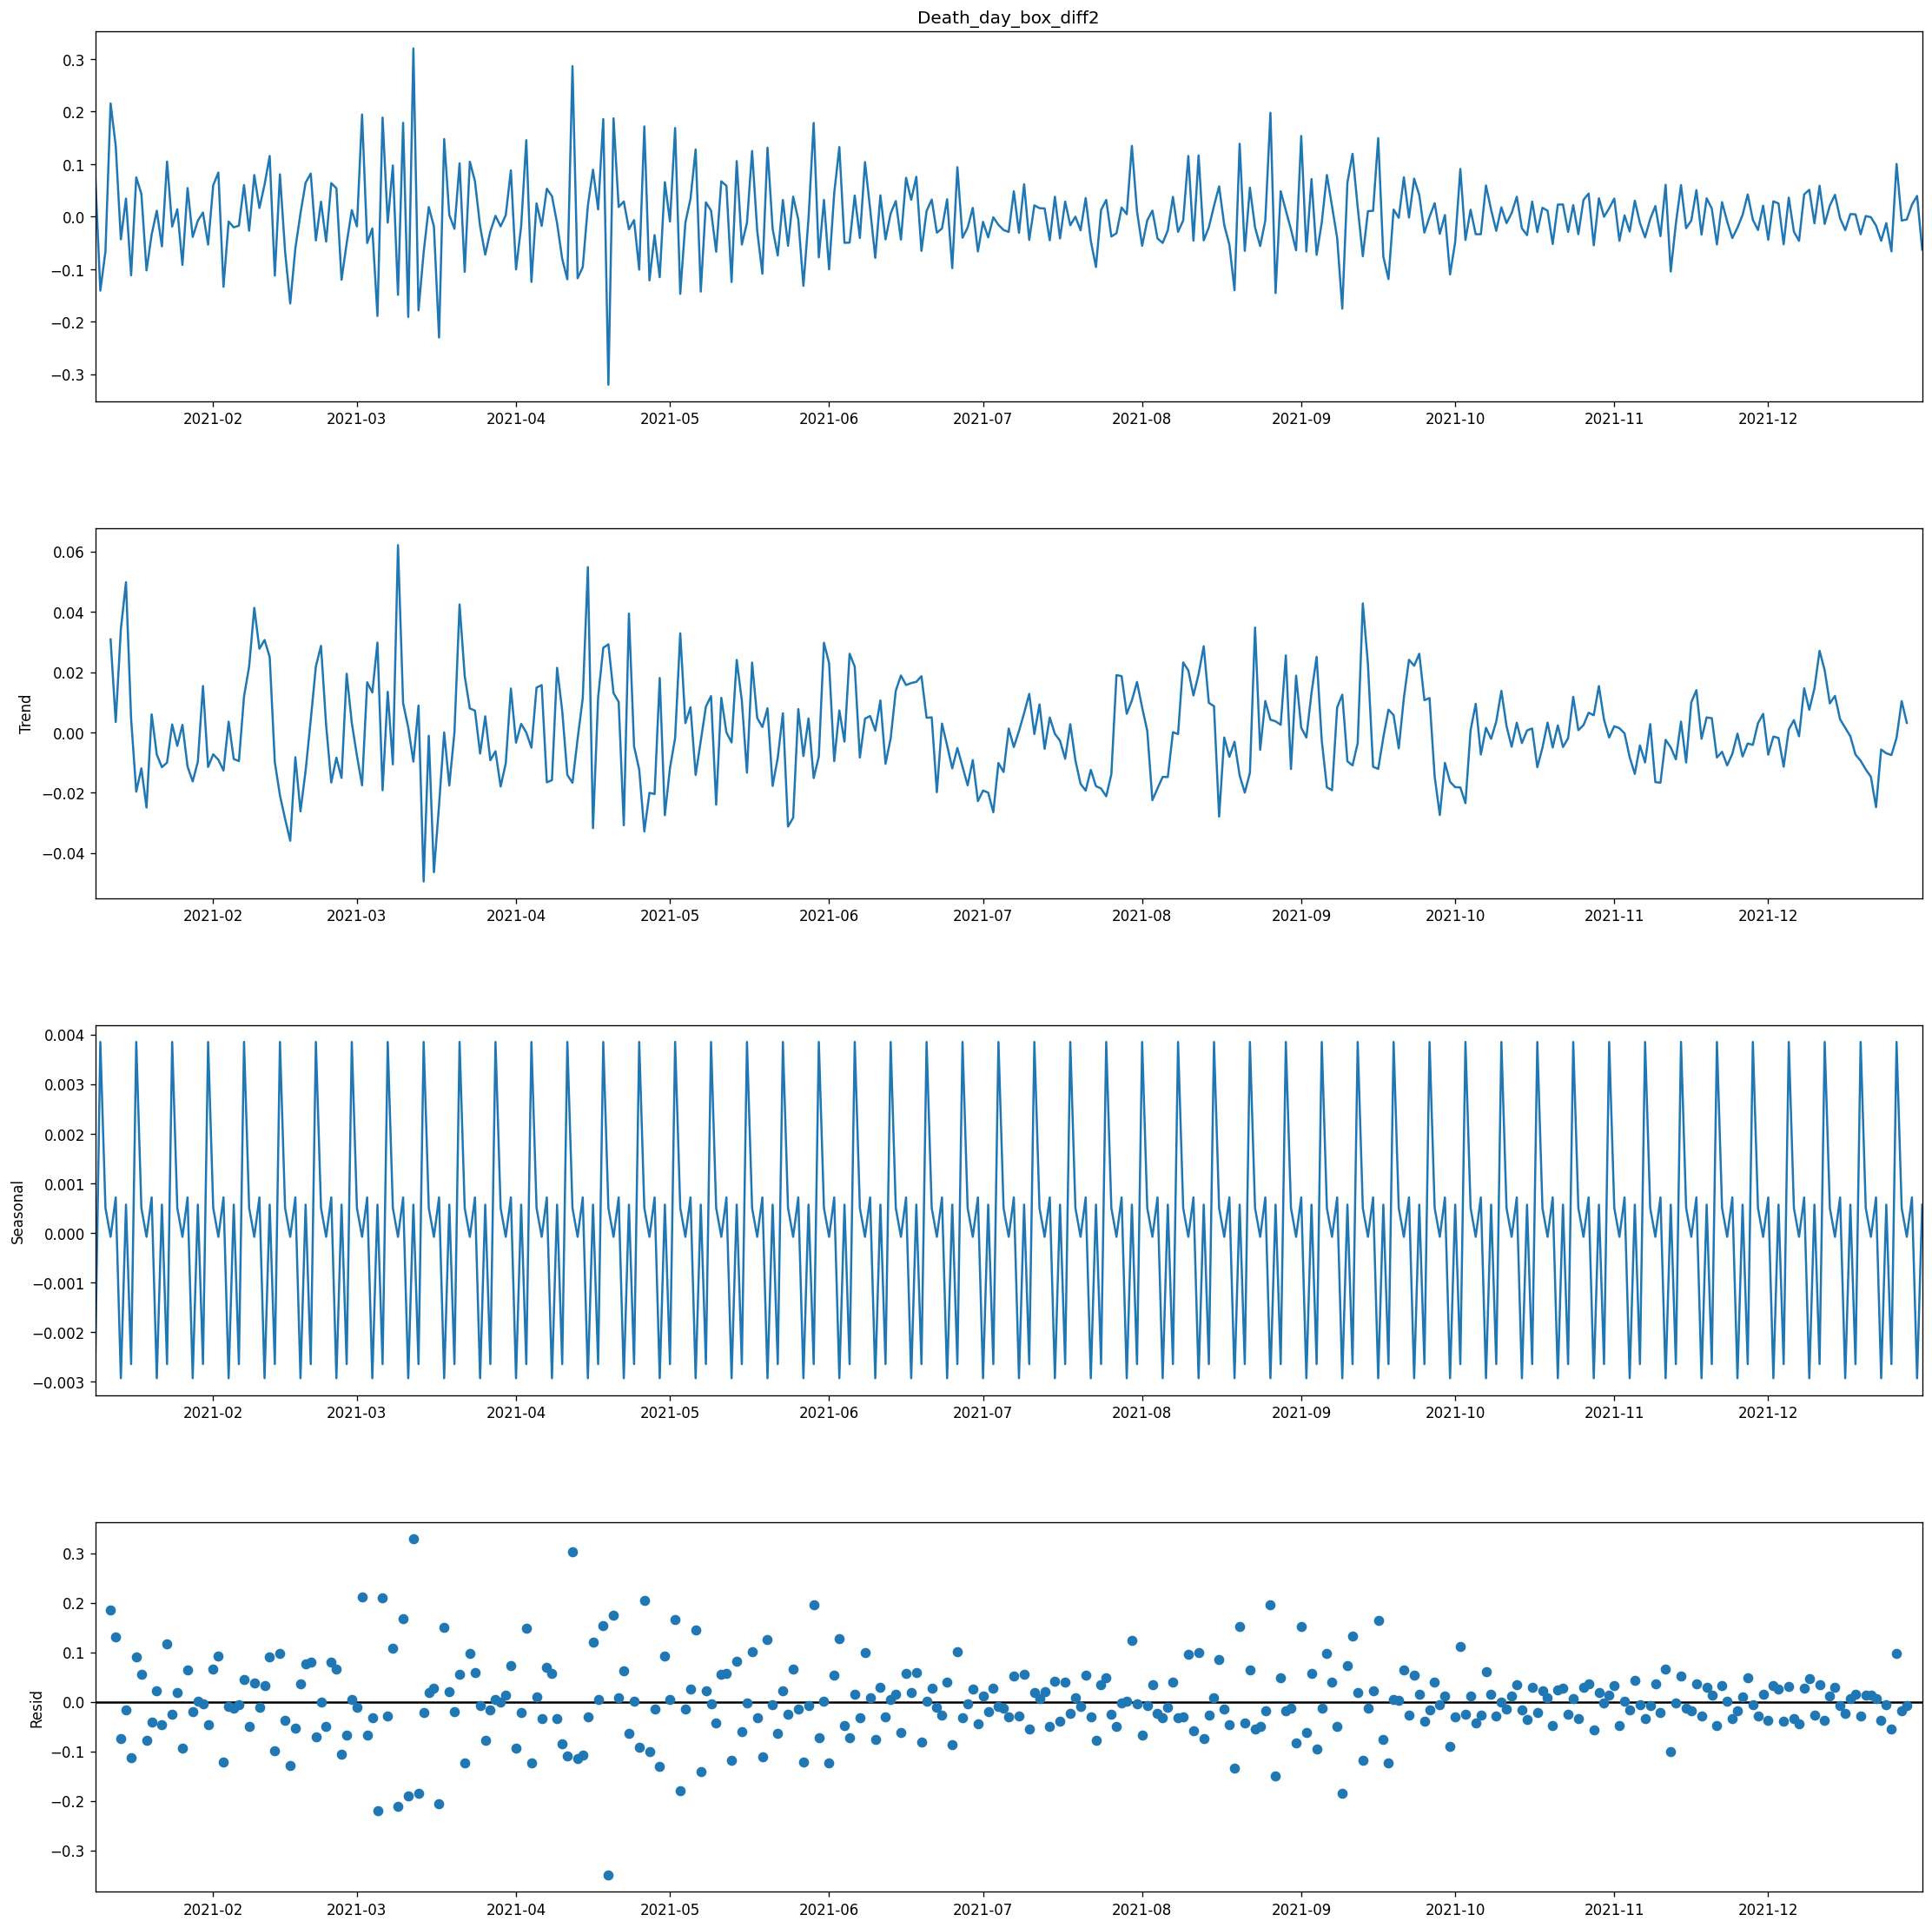

In [439]:
# additional 1-step difference

df_train['Death_day_box_diff2'] = df_train.Death_day_box_diff - df_train.Death_day_box_diff.shift(1)
fig = sm.tsa.seasonal_decompose(df_train.Death_day_box_diff2[8:]).plot()
fig.set_size_inches((20,20))
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(df_train.Death_day_box_diff2[8:])[1])

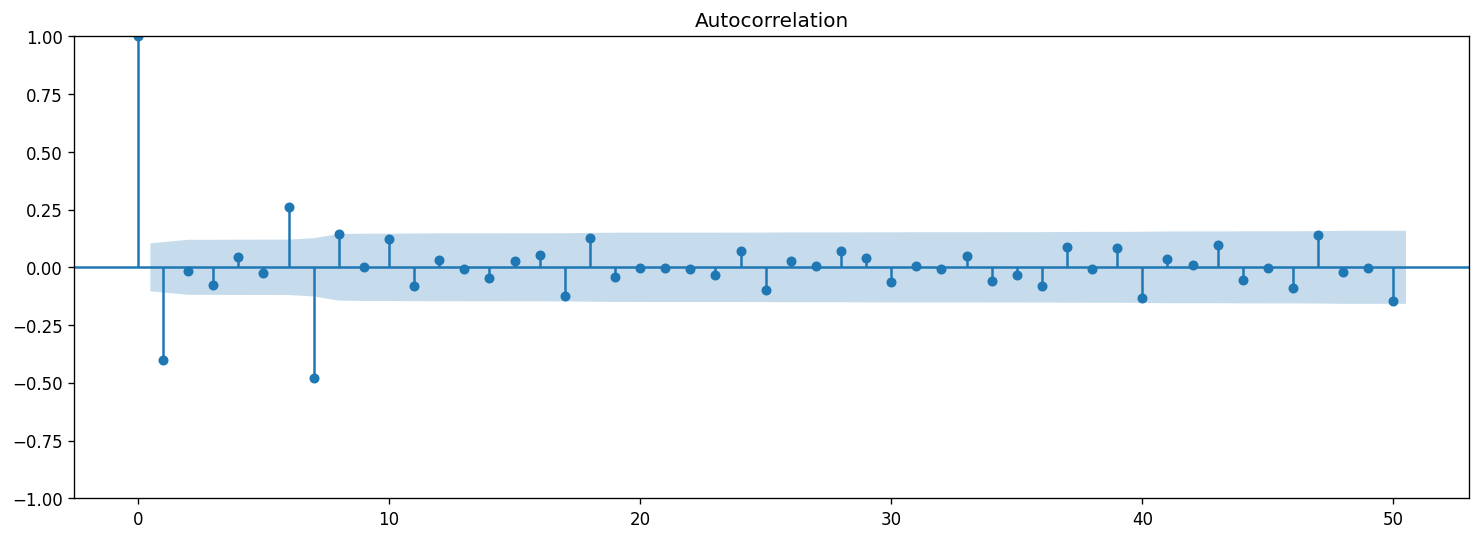

In [440]:
# let's calculate autocorrelation and partial autocorrelation components
# autocorrelation
fig = sm.graphics.tsa.plot_acf(df_train.Death_day_box_diff2[8:].values.squeeze(), lags=50)
fig.set_size_inches(15,5)

# q should be 2

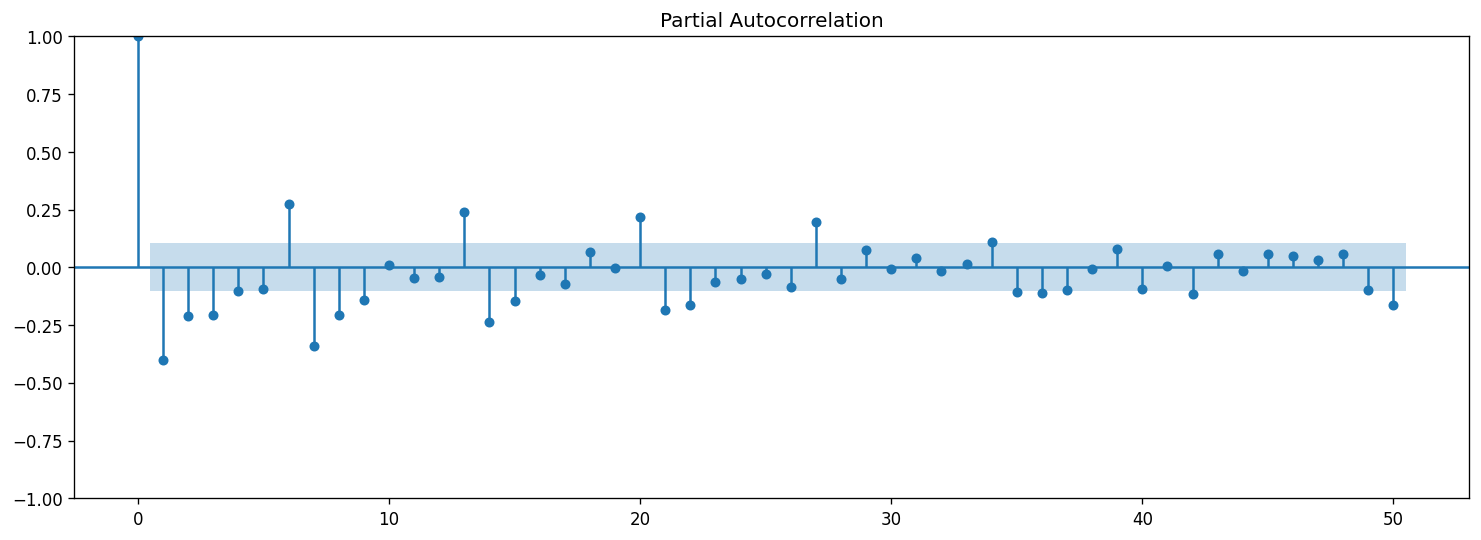

In [441]:
# partial autocorrelation
fig = sm.graphics.tsa.plot_pacf(df_train.Death_day_box_diff2[8:].values.squeeze(), lags=50)
fig.set_size_inches(15,5)


# p should be 2

# Try to find d param

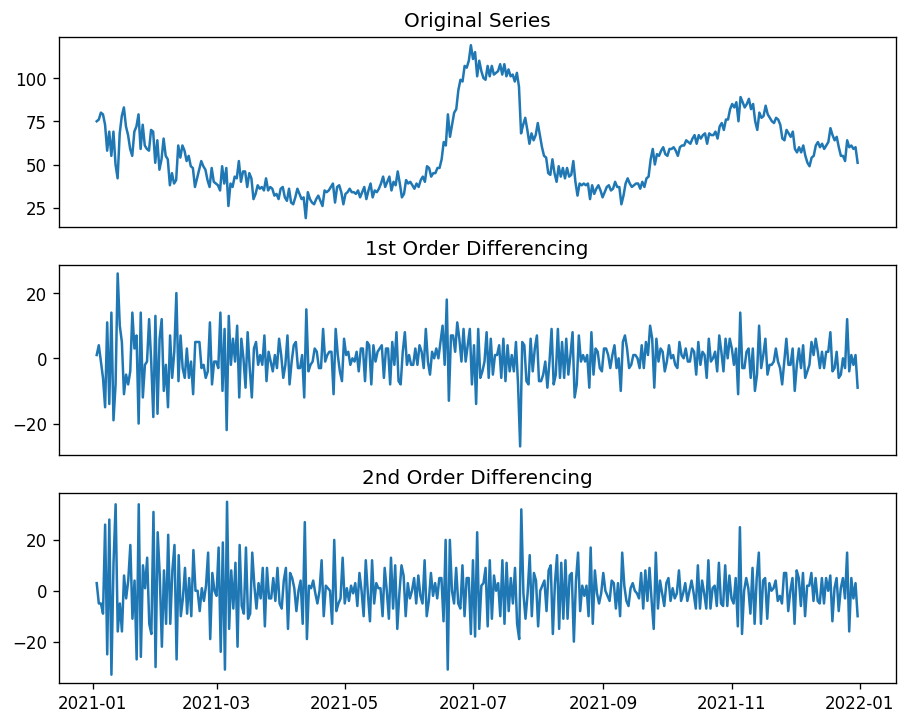

In [442]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_train.Death_day); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_train.Death_day.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_train.Death_day.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()


# Let's d = 1, because this first diff looks stable and has less noise

In [443]:
from itertools import product

# parameters for SARIMA model
# better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise

ps = range(0, 6)   # 2
d = 1
qs = range(0, 4)  # 2
Ps = range(0, 4)  # 3
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 96


In [444]:
import warnings
from tqdm import tqdm

results = []
best_aic = float("inf")

# ignore warnings
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):

    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Death_day_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)

    #print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

100%|██████████| 96/96 [02:27<00:00,  1.54s/it]

     parameters          aic
7  (5, 2, 3, 0) -1091.547662
6  (0, 1, 3, 0) -1088.337515
5  (0, 1, 2, 0) -1048.578588
4  (0, 1, 1, 0) -1002.897489
3  (0, 0, 3, 0) -1002.063663


In [445]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Death_day_box   No. Observations:                  365
Model:             SARIMAX(5, 1, 2)x(3, 1, [], 7)   Log Likelihood                 556.774
Date:                            Sun, 11 Sep 2022   AIC                          -1091.548
Time:                                    16:18:18   BIC                          -1048.893
Sample:                                01-01-2021   HQIC                         -1074.582
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9577      0.091    -10.554      0.000      -1.136      -0.780
ar.L2         -1.2997      0.101   

Student test: p=0.660310
Dickey-Fuller test: p=0.0000000000000000000000000


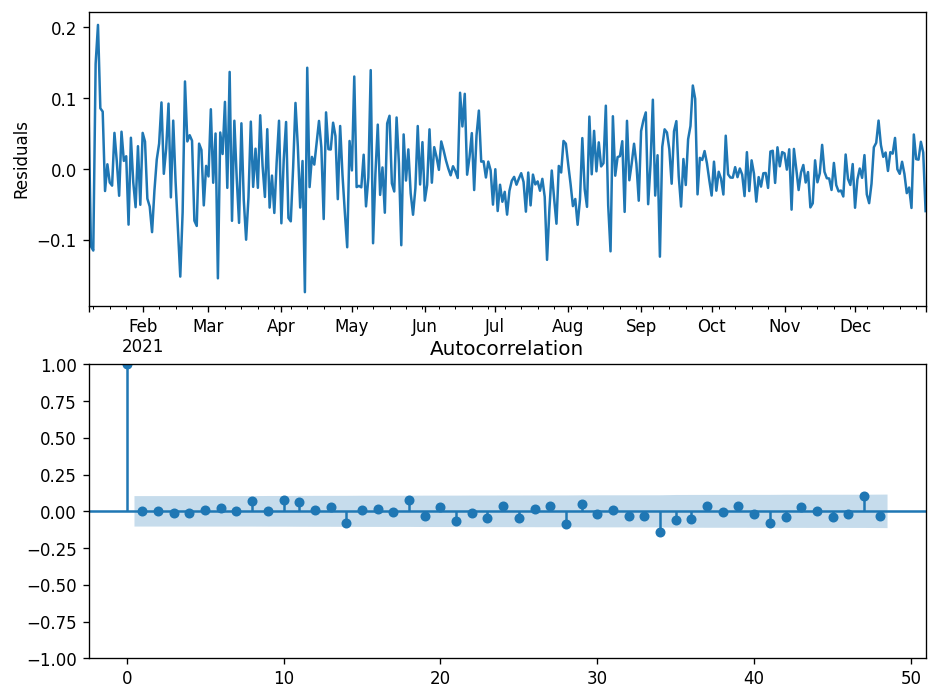

In [446]:
plt.subplot(211)
best_model.resid[8:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[8:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[8:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[8:])[1])

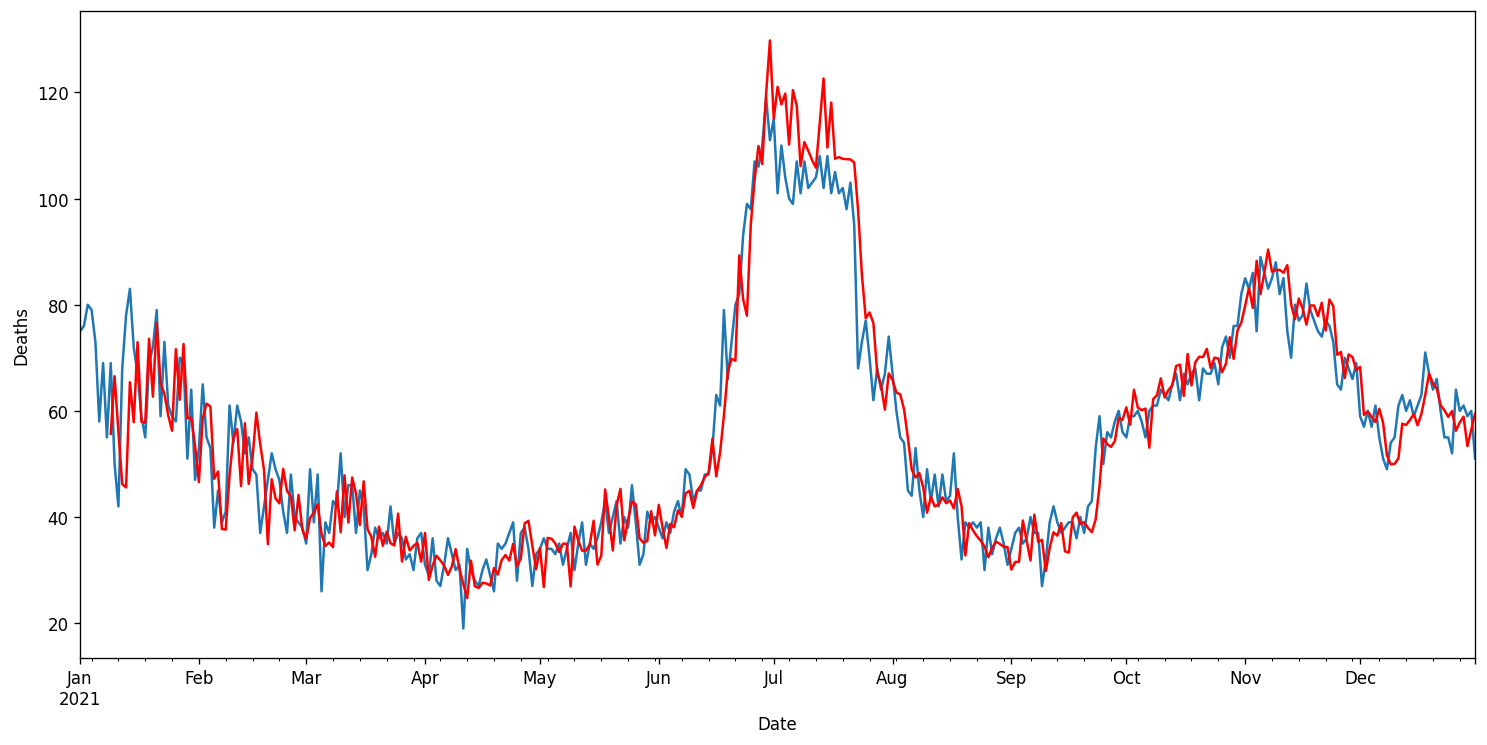

In [447]:
import pylab

df_train['SARIMA_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df_train.Death_day.plot()
df_train.SARIMA_model[8:].plot(color='r')
plt.ylabel('Deaths')
pylab.show()


# Evaluation Metrics Train


In [448]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

R2 = r2_score(df_train['Death_day'][8:], df_train['SARIMA_model'][8:])
MAPE = mean_absolute_percentage_error(df_train['Death_day'][8:], df_train['SARIMA_model'][8:])
print('MAPE:{} \n R2 score:{}'.format(MAPE, R2))

MAPE:0.09930979223705214 
 R2 score:0.8928112579487268


# Forecast next 60 days

In [449]:
from dateutil.relativedelta import relativedelta
import datetime

df_sarima_forecast = pd.concat([df_train[['Death_day']],df_test[['Death_day']]])
date_list = [datetime.datetime.strptime("2021-12-31", "%Y-%m-%d") + relativedelta(days=x) for x in range(1,61)]
future = pd.DataFrame(index=date_list, columns= df_sarima_forecast.columns)
df_sarima_forecast['forecast'] = invboxcox(best_model.predict(start=365, end=425), lmbda)

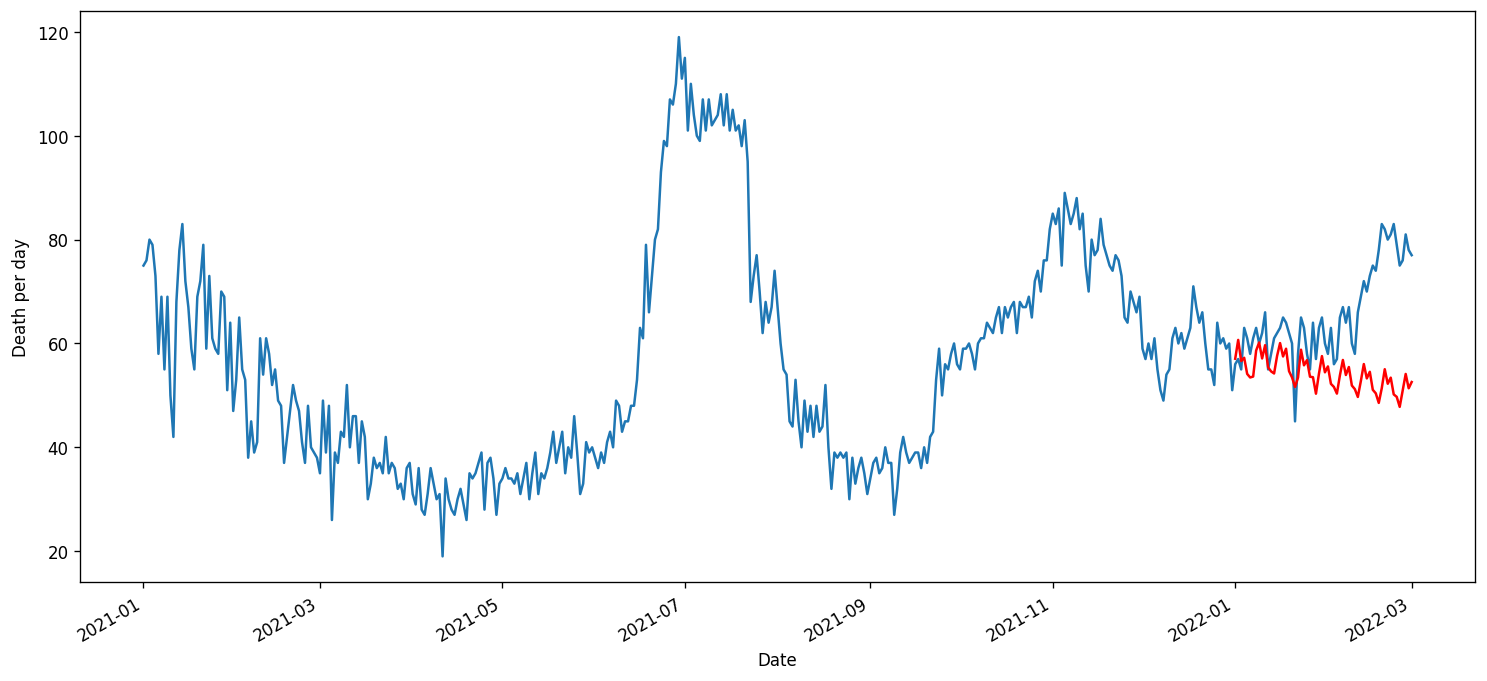

In [450]:
plt.figure(figsize=(15,7))
df_sarima_forecast.Death_day.plot()
df_sarima_forecast.forecast.plot(color='r')
plt.ylabel('Death per day')
pylab.show()

# Evaluation Metrics Test


In [451]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

R2 = r2_score(df_sarima_forecast['Death_day'][366:], df_sarima_forecast['forecast'][366:])
MAPE = mean_absolute_percentage_error(df_sarima_forecast['Death_day'][366:], df_sarima_forecast['forecast'][366:])
print('MAPE:{} \n R2 score:{}'.format(MAPE, R2))

MAPE:0.165979354126007 
 R2 score:-2.0882288357544234


In [452]:
# kekw :)

# LSTM
Good paper about it - https://bobrupakroy.medium.com/multi-step-lstm-time-series-forecasting-6d9e4777883b

In [453]:
df.head()

,Death_day
Date,
2021-01-01,75
2021-01-02,76
2021-01-03,80
2021-01-04,79
2021-01-05,73


In [454]:
df_train = df_train[["Death_day"]]
df_test = df_test[["Death_day"]]
df = df[["Death_day"]]

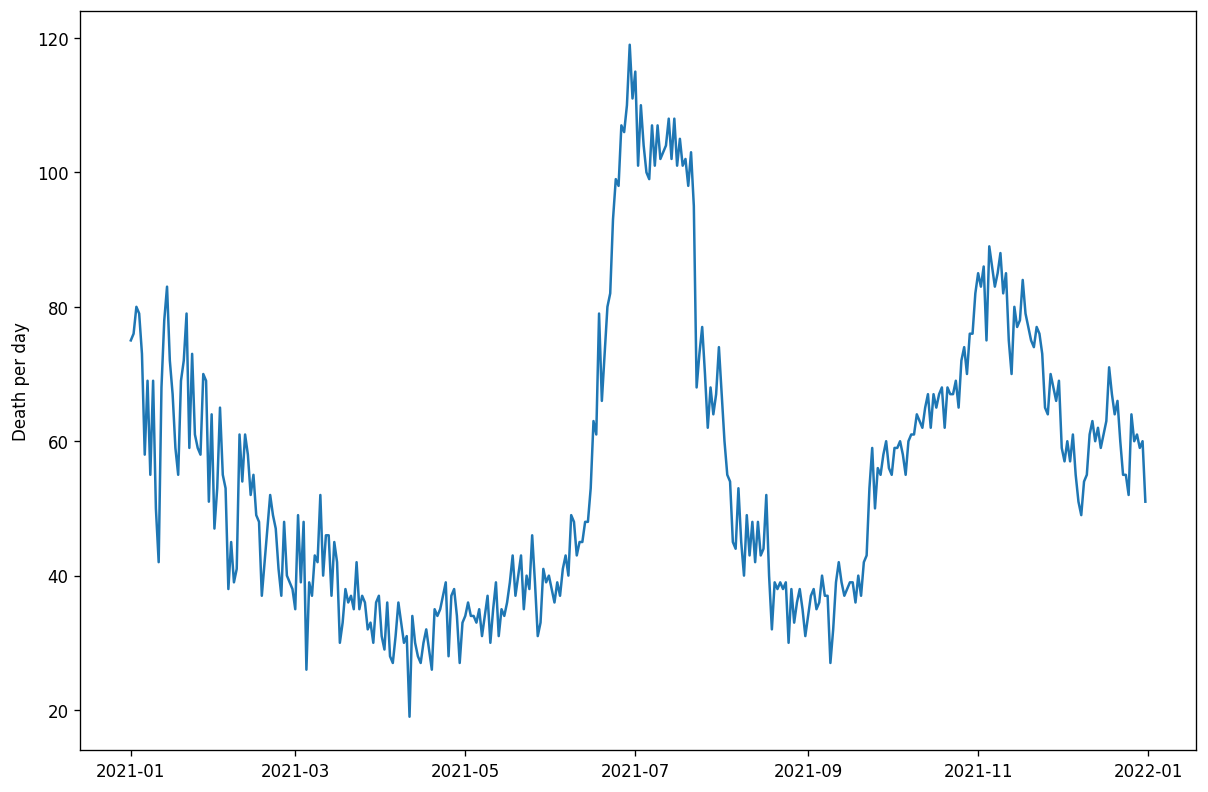

In [455]:
plt.figure(figsize=(12,8))
plt.plot(df_train)
plt.ylabel('Death per day')
plt.show()

In [456]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;

    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted



In [457]:
# hyperparameters initialization and training the model

n_lag = 8
n_seq = 1
n_test = 60
n_epochs = 40
n_batch = 1
n_neurons =  4

scaler, train, test = prepare_data(df, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(df, forecasts, scaler, n_test+2)

forecasts = [x[0] for x in forecasts]

0
320/320 [==============================] - 2s 3ms/step - loss: 0.0711 - val_loss: 0.0292
1
320/320 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0289
2
320/320 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0288
3
320/320 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0288
4
320/320 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0290
5
320/320 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.0292
6
320/320 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0295
7
320/320 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0299
8
320/320 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0303
9
320/320 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0307
10
320/320 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.031

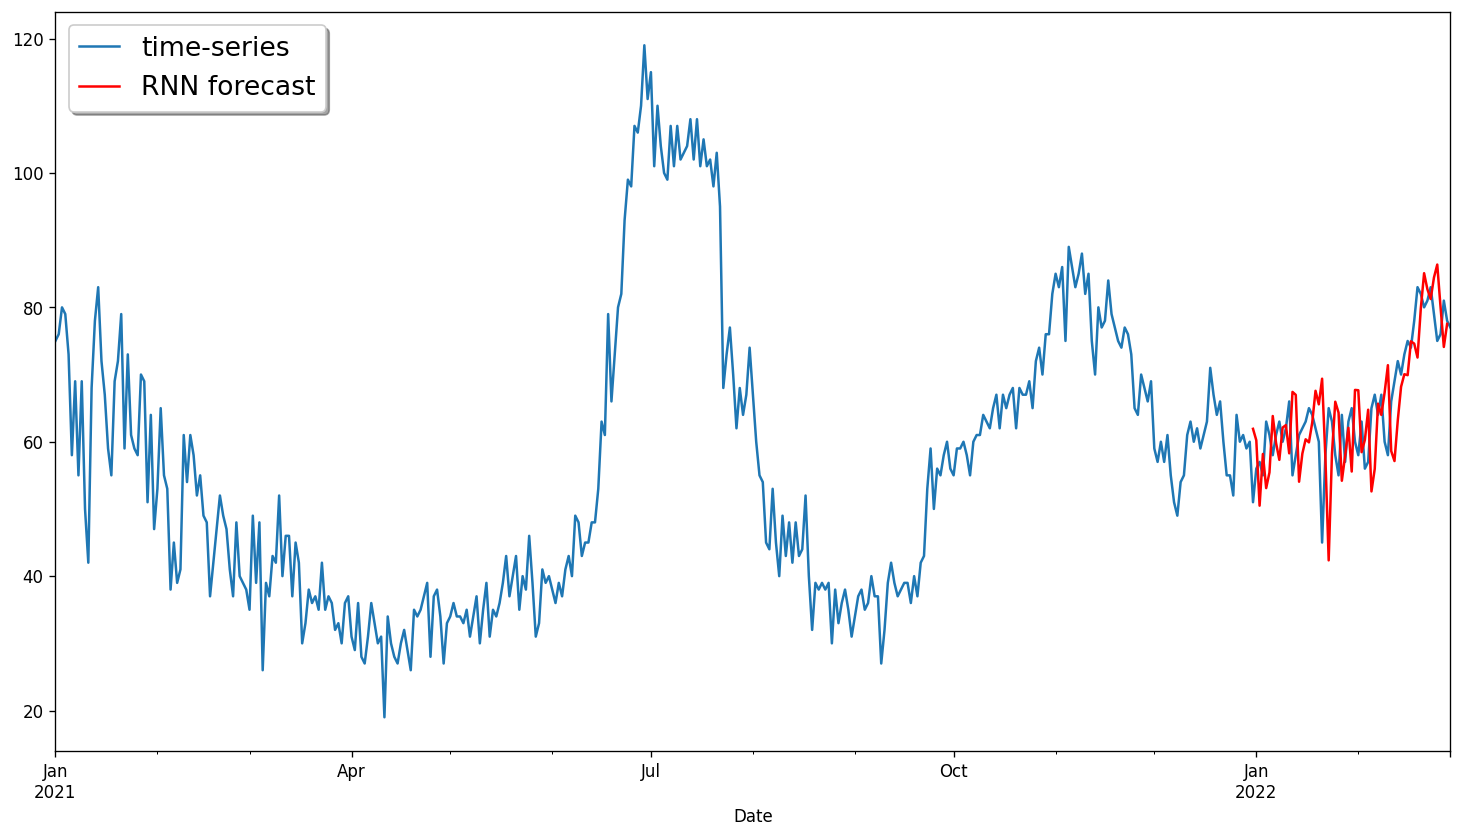

In [469]:
# visualize

fig=plt.figure(figsize=(15,8))
df.Death_day.plot()

date_list = [datetime.datetime.strptime("2021-12-31", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,60)]
future = pd.DataFrame(data=forecasts, index=date_list, columns=["forecast"])
future.forecast.plot(color="r")

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


# Evaluation Metrics Test


In [466]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

R2 = r2_score(df_test['Death_day'][:-1], future['forecast'])
MAPE = mean_absolute_percentage_error(df_test['Death_day'][:-1], future['forecast'])
print('MAPE:{} \n R2 score:{}'.format(MAPE, R2))

MAPE:0.10236894508376702 
 R2 score:0.1644148773262163


# Conclusion

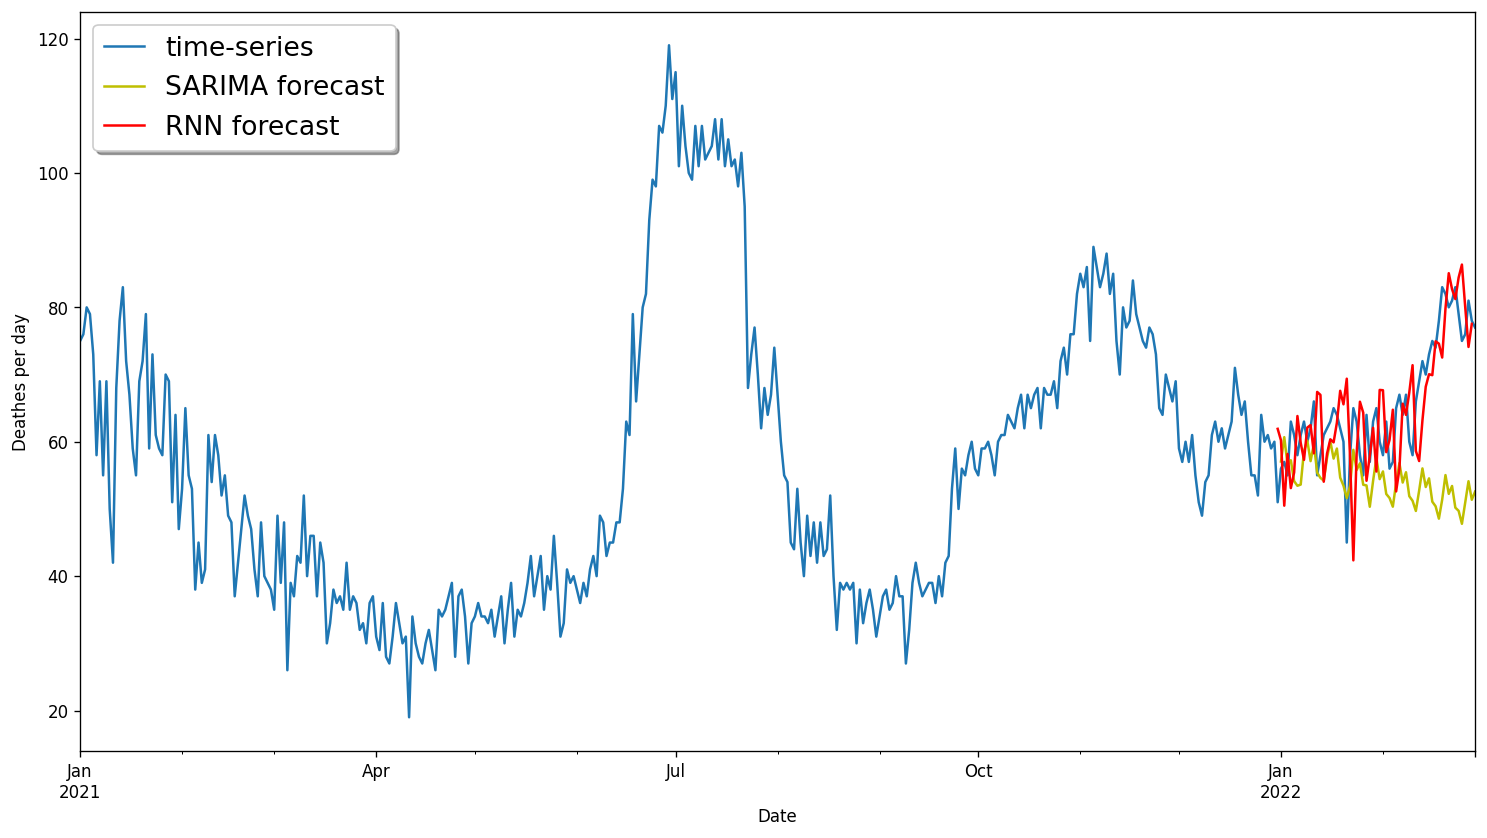

In [472]:
# let's show both forecasting on the graph
fig=plt.figure(figsize=(15,8))

df.Death_day.plot()

df_sarima_forecast.forecast.plot(color="y")

future.forecast.plot(color="r")

plt.ylabel("Deathes per day")

plt.legend(('time-series', 'SARIMA forecast', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [ ]:
# Well, it's obvious that multi-step LSTM works better than SARIMA. Test mestrics show the same.
# It's probably because time series has much unpredictable behaviour and LSTM has managed to handle it better.